In [23]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [24]:
# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

#求樣本大小
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


In [25]:
df = pd.read_csv('ab_data.csv')
df.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


In [26]:
df.info()
pd.crosstab(df['group'], df['landing_page'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [27]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
multi_users

3894

In [28]:
users_to_drop = session_counts[session_counts > 1].index
df = df[~df['user_id'].isin(users_to_drop)]
df.shape[0]

286690

In [29]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test.head(3)

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0


In [30]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [31]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [32]:
conversion_rates = ab_test.groupby('group')['converted']
std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


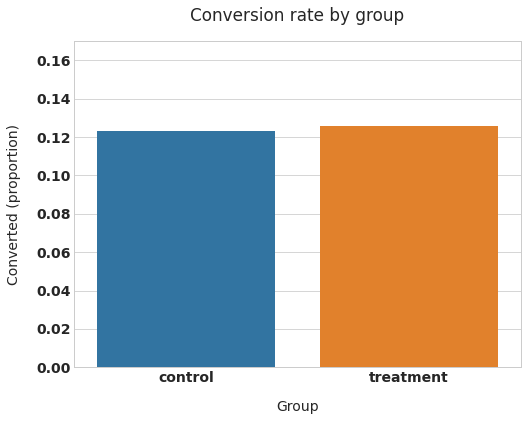

In [36]:
plt.figure(figsize=(8,6))
sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)
plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [37]:

#以函數計算z_stat, pval, confidence interval
#因為前面importt statsmodels.stats.api as sms，
#z_stat, pval = sms.proportions_ztest(successes, nobs=nobs)
#(lower_con, lower_treat), (upper_con, upper_treat) = sms.proportion_confint(successes, nobs=nobs, alpha=0.05)
#而無須 from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
#二項式的信賴區間
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')
#判讀統計結果(z值、z的p值、對照組的信賴區間、處理組的信賴區間)

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


15970


landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


There are 3894 users that appear multiple times in the dataset
The updated dataset now has 286690 entries


,conversion_rate,std_deviation,std_error
group,,,
control,0.121,0.326,0.003
treatment,0.121,0.326,0.003


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


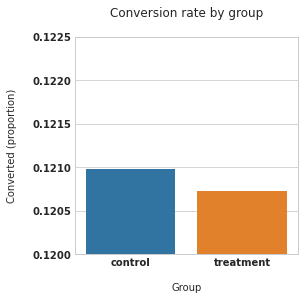

z statistic: 0.07
p-value: 0.945
ci 95% for control group: [0.116, 0.126]
ci 95% for treatment group: [0.116, 0.126]


In [38]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
%matplotlib inline

#更動效應值
effect_size = sms.proportion_effectsize(0.12, 0.11)    
required_n2 = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1)                                                  
required_n2 = ceil(required_n2)                                                  
print(required_n2)
df2 = pd.read_csv('ab_data.csv')
# 用 crosstab 將 landing_page 當作 column，group 當作 row
display(pd.crosstab(df2['group'], df2['landing_page']))
#偵測重複值
repeat_counts = df2['user_id'].value_counts(ascending=False)
multi_users = repeat_counts[repeat_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')
#除去重複值
users_to_drop = repeat_counts[repeat_counts > 1].index
df2 = df2[~df2['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df2.shape[0]} entries')
#分組，分為對照組與處理組後合併回一表，重排索引
S_control = df2[df2['group'] == 'control'].sample(n=required_n2, random_state=22)
S_treatment = df2[df2['group'] == 'treatment'].sample(n=required_n2, random_state=22)
ab_test2 = pd.concat([S_control, S_treatment], axis=0)
ab_test2.reset_index(drop=True, inplace=True)
#確認樣本數
ab_test2['group'].value_counts()
#計算conversion rate 平均值，標準差，標準誤差
conversion_rates = ab_test2.groupby('group')['converted']
#ddof=0：母體標準差，ddof=1，樣本標準差
std_p2 = lambda x: np.std(x, ddof=0)   # Standard deviation
se_p2 = lambda x: stats.sem(x, ddof=0) # Standard error：(std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p2, se_p2])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
display(conversion_rates.style.format('{:.3f}'))

#繪製長條圖
plt.figure(figsize=(4,4))
sns.barplot(x=ab_test2['group'], y=ab_test2['converted'], ci=False)
plt.ylim(0.12, 0.1225)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)
plt.show()

#Z檢定與信賴區間
control_results2 = ab_test2[ab_test2['group'] == 'control']['converted']
treatment_results2 = ab_test2[ab_test2['group'] == 'treatment']['converted']
n_con2 = control_results2.count()
n_treat2 = treatment_results2.count()
successes2 = [control_results2.sum(), treatment_results2.sum()]
nobs2 = [n_con2, n_treat2]

z_stat2, pval2 = proportions_ztest(successes2, nobs=nobs2)
(lower_con2, lower_treat2), (upper_con2, upper_treat2) = proportion_confint(successes2, nobs=nobs2, alpha=0.05)

print(f'z statistic: {z_stat2:.2f}')
print(f'p-value: {pval2:.3f}')
print(f'ci 95% for control group: [{lower_con2:.3f}, {upper_con2:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat2:.3f}, {upper_treat2:.3f}]')